# Climate Analysis and Exploration

## Set Up

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime as dt

In [2]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

# Inspect the database for its tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [3]:
# Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
start = dt.date(2018, 4, 24)
end = dt.date(2018, 5, 1)
print(f"Start: {start}")
print(f"End: {end}")

Start: 2018-04-24
End: 2018-05-01


In [4]:
# Use SQLAlchemy `automap_base()` to reflect your tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save a reference to those classes called `Station` and `Measurement`
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session for the engine to manipulate data
session = Session(engine)

# Test out the session by counting the number of rows
session.query(func.count(Measurement.station)).all()

[(18103)]

## Precipitation Analysis

In [5]:
# Find most recent date of records
date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_query_results = list(np.ravel(date_query))
date_split = date_query_results[0].split('-')
current_year = dt.date(int(date_split[0]), int(date_split[1]), int(date_split[2]))

# Design a query to retrieve the last 12 months of precipitation data.
last_year = current_year - dt.timedelta(days=365)
prcp_query = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= last_year).\
            order_by(Measurement.date)

# Load the query results into a Pandas DataFrame and set the index to the date column.
percipitation_df = pd.read_sql_query(prcp_query.statement, engine)
percipitation_df = percipitation_df.set_index('date')
percipitation_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


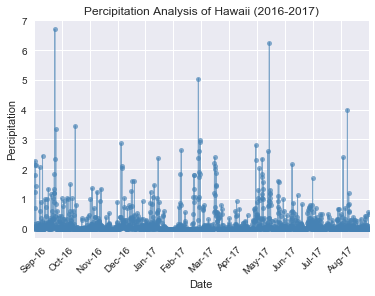

In [6]:
# Plot the results using the DataFrame `plot` method
x_axis = len(percipitation_df["prcp"])
plt.plot(np.arange(x_axis),percipitation_df["prcp"], marker="o", 
                 color='steelblue', markersize=5, linewidth=1, alpha=0.65)
plt.title(f"Percipitation Analysis of Hawaii (2016-2017)", fontdict={'fontsize':12})
plt.xlabel("Date")
plt.ylabel("Percipitation")
plt.ylim(-0.30,7)
plt.xlim(0, 2015)
plt.xticks(np.arange(0,2015, (2015/12)),('Sep-16', 'Oct-16', 'Nov-16', 'Dec-16', 'Jan-17', 'Feb-17', \
                                         'Mar-17', 'Apr-17', 'May-17', 'Jun-17', 'Jul-17', 'Aug-17'), rotation=45)

plt.show()

In [7]:
# Use Pandas to print the summary statistics for the precipitation data
percipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [8]:
# Design a query to calculate the total number of stations.
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

# or session.query(func.count(Station.station)).all()

9

In [9]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
active_query = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    filter(Measurement.station == Station.station).\
                    order_by(func.count(Measurement.tobs).desc())
print("Most Active Stations")            
for activity in active_query:
    (_station, _name, _count) = activity
    print('-'*52)
    print(f"Station: {_station}")
    print(f"Station Name: {_name}")
    print(f"Observation Count: {_count}")

Most Active Stations
----------------------------------------------------
Station: USC00519281
Station Name: WAIHEE 837.5, HI US
Observation Count: 2772
----------------------------------------------------
Station: USC00513117
Station Name: KANEOHE 838.1, HI US
Observation Count: 2696
----------------------------------------------------
Station: USC00519397
Station Name: WAIKIKI 717.2, HI US
Observation Count: 2685
----------------------------------------------------
Station: USC00519523
Station Name: WAIMANALO EXPERIMENTAL FARM, HI US
Observation Count: 2572
----------------------------------------------------
Station: USC00516128
Station Name: MANOA LYON ARBO 785.2, HI US
Observation Count: 2484
----------------------------------------------------
Station: USC00514830
Station Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Observation Count: 1937
----------------------------------------------------
Station: USC00511918
Station Name: HONOLULU OBSERVATORY 702.2, HI US
Observation Count: 1

In [10]:
# Which station has the highest number of observations?
most_active_station = session.query(Station.name).\
                    group_by(Measurement.station).\
                    filter(Measurement.station == Station.station).\
                    order_by(func.count(Measurement.tobs).desc()).first()
for x in most_active_station:
    Station_name=x
    print(f"The most active station is: {Station_name}")

The most active station is: WAIHEE 837.5, HI US


In [11]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
tobs_query = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= last_year).\
                    order_by(Measurement.date)
            
# Load the query results into a Pandas DataFrame and set the index to the date column.
temperature_df = pd.read_sql_query(tobs_query.statement, engine)
temperature_df.head()

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


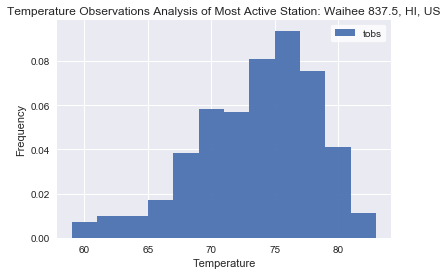

In [12]:
# Plot the results as a histogram with `bins=12`
plt.hist(temperature_df['tobs'], normed=True, bins=12, alpha=0.95, label='tobs')

# Set title
plt.title('Temperature Observations Analysis of Most Active Station: Waihee 837.5, HI, US')

# Customize legend
legend1 = plt.legend(frameon = 1)
frame1 = legend1.get_frame()
frame1.set_color('white')

# Set axes labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Show plot
plt.show()

## Temperature Analysis

In [13]:
# Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    calculations = [func.min(Measurement.tobs),
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs)]
    query = session.query(*calculations).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).all()
    results = list(np.ravel(query))
    return(results)
    
# Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip
# using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
start_date = start - dt.timedelta(days=365)
end_date = end - dt.timedelta(days=365)

t = calc_temps(start_date, end_date)

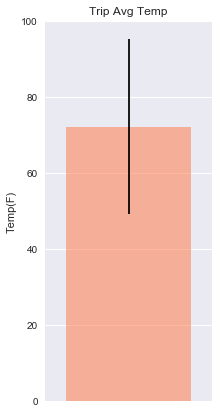

In [14]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
tmin = t[0]
tavg = t[1]
tmax = t[2]

x = 1
y = tavg

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
yerr = (tmax - tmin)

# Adjust figure size
plt.figure(figsize=(3,7))

# Create bar chart
plt.bar(x, y, align='center', width=1.5, color='coral', alpha=0.55)

# Create errorbar
plt.errorbar(x, y, yerr, color='black')

# Set axes limits and labels
plt.xlim(0, 2 ,1)
plt.ylim(0,100)
plt.xticks([])
plt.ylabel('Temp(F)')

# Set title
plt.title("Trip Avg Temp")

# Show plot
plt.show()

## Daily Normals Analysis

In [15]:
# Calculate the rainfall per weather station using the previous year's matching dates
calculations = [func.min(Measurement.prcp),\
                func.avg(Measurement.prcp),\
                func.max(Measurement.prcp)]
challenge_query = session.query(Station.name, *calculations).\
            filter(Measurement.station == Station.station).\
            filter(func.strftime("%Y-%m-%d", Measurement.date) > last_year).\
            filter(func.strftime("%Y-%m-%d", Measurement.date) < current_year).\
            group_by(Measurement.station)

print("Rainfall per Weather Station")            
for rainfall in challenge_query:
    (r_station, r_min, r_avg, r_max) = rainfall
    print('-'*52)
    print(f"Station: {r_station}")
    print(f"Min Percipitation: {r_min}")
    print(f"Avg Percipitation: {r_avg}")
    print(f"Max Percipitation: {r_max}")

Rainfall per Weather Station
----------------------------------------------------
Station: KANEOHE 838.1, HI US
Min Percipitation: 0.0
Avg Percipitation: 0.1414035087719299
Max Percipitation: 2.9
----------------------------------------------------
Station: KUALOA RANCH HEADQUARTERS 886.9, HI US
Min Percipitation: 0.0
Avg Percipitation: 0.1261977186311787
Max Percipitation: 2.39
----------------------------------------------------
Station: MANOA LYON ARBO 785.2, HI US
Min Percipitation: 0.0
Avg Percipitation: 0.4498773006134971
Max Percipitation: 6.7
----------------------------------------------------
Station: PEARL CITY, HI US
Min Percipitation: 0.0
Avg Percipitation: 0.0765
Max Percipitation: 2.4
----------------------------------------------------
Station: WAIHEE 837.5, HI US
Min Percipitation: 0.0
Avg Percipitation: 0.1944159544159545
Max Percipitation: 2.98
----------------------------------------------------
Station: WAIKIKI 717.2, HI US
Min Percipitation: 0.0
Avg Percipitation:

In [16]:
# Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.
calculations2 = [func.min(Measurement.tobs),\
                func.avg(Measurement.tobs),\
                func.max(Measurement.tobs)]
challenge_query2 = session.query(Station.name, *calculations2).\
            filter(Measurement.station == Station.station).\
            filter(func.strftime("%Y-%m-%d", Measurement.date) > last_year).\
            filter(func.strftime("%Y-%m-%d", Measurement.date) < current_year).\
            group_by(Measurement.station)
print("Daily Normals")      
for daily_normals in challenge_query2:
    (t_station, t_min, t_avg, t_max) = daily_normals
    print('-'*52)
    print(f"Station: {t_station}")
    print(f"Min Temperature: {t_min}")
    print(f"Avg Temperature: {t_avg}")
    print(f"Max Temperature: {t_max}")

Daily Normals
----------------------------------------------------
Station: KANEOHE 838.1, HI US
Min Temperature: 61
Avg Temperature: 73.26900584795321
Max Temperature: 82
----------------------------------------------------
Station: KUALOA RANCH HEADQUARTERS 886.9, HI US
Min Temperature: 63
Avg Temperature: 77.16349809885932
Max Temperature: 83
----------------------------------------------------
Station: MANOA LYON ARBO 785.2, HI US
Min Temperature: 58
Avg Temperature: 71.99386503067484
Max Temperature: 82
----------------------------------------------------
Station: PEARL CITY, HI US
Min Temperature: 62
Avg Temperature: 73.88333333333334
Max Temperature: 81
----------------------------------------------------
Station: WAIHEE 837.5, HI US
Min Temperature: 59
Avg Temperature: 73.0968660968661
Max Temperature: 83
----------------------------------------------------
Station: WAIKIKI 717.2, HI US
Min Temperature: 60
Avg Temperature: 75.16526610644257
Max Temperature: 87
-----------------

In [17]:
# Create a function called `daily_normals` that will calculate the daily normals for a specific date. 
# This date string will be in the format `%m-%d`. 
# Be sure to use all historic tobs that match that date string
def daily_normals(date):
    daily_calc = [func.min(Measurement.tobs),\
                    func.avg(Measurement.tobs),\
                    func.max(Measurement.tobs)]
    daily_query = session.query(*daily_calc).\
                filter(func.strftime("%m-%d", Measurement.date) == date).all()
    x = list(np.ravel(daily_query))
    return(x)

In [23]:
# Create a list of dates for your trip in the format `%m-%d`.
trip_dates = []
# delta = end_date - start_date
# for i in range(delta.days+1):
#     trip_dates.append((start_date + dt.timedelta(days=i)).strftime("%m-%d"))

date_range = pd.date_range(start_date, end_date, freq="d")
for d in date_range:
    trip_dates.append(d.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# Append the results to a list
trip_min = []
trip_avg = []
trip_max = []
for date in trip_dates:
    trip_min.append(daily_normals(date)[0])
    trip_avg.append(daily_normals(date)[1])
    trip_max.append(daily_normals(date)[2])

In [24]:
# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date
daily_df = pd.DataFrame({'Date': trip_dates,
                         'Min Temp': trip_min,
                         'Avg Temp': trip_avg,
                         'Max Temp': trip_max})
daily_df = daily_df.set_index('Date')
daily_df

,Avg Temp,Max Temp,Min Temp
Date,,,
04-24,73.038462,79.0,67.0
04-25,73.836364,83.0,66.0
04-26,74.018519,81.0,66.0
04-27,72.784314,81.0,65.0
04-28,73.244898,79.0,63.0
04-29,72.920000,78.0,66.0
04-30,71.660000,78.0,58.0
05-01,72.759259,79.0,65.0


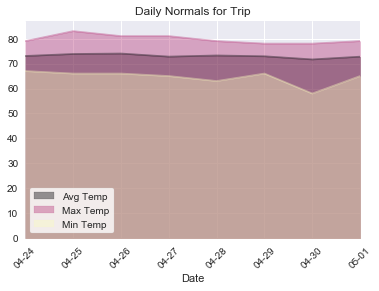

In [25]:
daily_df.plot(kind='area', stacked=False,alpha=0.4, colormap='magma', title='Daily Normals for Trip')
plt.xticks(rotation=45)
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()